# Moon Data Classification

This is a demonstration of how to run custom PyTorch model using SageMaker. We are going to implement a non-linear binary classifier that can create a non-linear separation of moon data from `sklearn`. 

## Moon Data

`sklearn` provides utility functions to generate data that look like two moon shapes when they are displayed and they are often referred to as **moon data**.

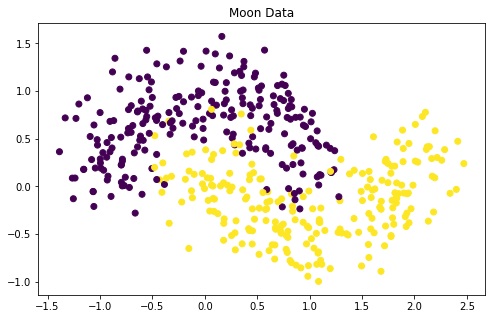

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

%matplotlib inline

np.random.seed(0)
num_points = 600
noise_val = 0.25

X, labels = make_moons(num_points, noise=noise_val)
X_train, X_test, labels_train, labels_test = train_test_split(X, labels, test_size=0.25, random_state=1)

plt.figure(figsize=(8,5))
plt.scatter(X_train[:,0], X_train[:, 1], c=labels_train)
plt.title('Moon Data')
plt.show()

## Data Preparation

Let's initialize the session and configure bucket and format for data upload. 

In [5]:
import boto3
import sagemaker

session = sagemaker.Session(default_bucket='machine-learning-case-studies')
role = sagemaker.get_execution_role()
bucket = session.default_bucket()

print('Initialized SageMaker session with default bucket {}'.format(bucket))

Initialized SageMaker session with default bucket machine-learning-case-studies


SageMaker expects CSV files as input for both training inference. The CSV files should be a certain format, according to [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/cdf-training.html)

> Amazon SageMaker requires that a CSV doesn't have a header record and that the target variable is in the first
  column
  
In order to achieve the desired format of our data, we should use DataFrame to perform the CSV parsing. We should define a function for this task because we don't want a DataFrame to take up unnecessary memory after we are done with it. We define it within the function scope, and when function returns, let garbage collection collects it.

In [6]:
import os


def to_csv(x, y, data_dir, filename):
    """
    Parse features and labels into one csv file with labels in the first column
    """
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    
    df = pd.concat([pd.DataFrame(y), pd.DataFrame(x)], axis=1)
    df.to_csv(os.path.join(data_dir, filename), header=False, index=False)

# Local data directory refers to the filesystem on SageMaker notebook instance.
local_data_dir = 'data'

to_csv(X_train, labels_train, local_data_dir, filename='train.csv')

Once the CSV is inside the data directory, we can upload it to S3 using SageMaker helper function.

In [7]:
# S3 bucket prefix for better organization of projects
s3_prefix = 'moon-data-classification'
s3_input_data_path = session.upload_data(path=local_data_dir, bucket=bucket, key_prefix=s3_prefix)
print('Data are uploaded to {}'.format(s3_input_data_path))

Data are uploaded to s3://machine-learning-case-studies/moon-data-classification


## PyTorch Model

We need to create a directory for our PyTorch scripts. The scripts will define a simple 3-layer neural network that uses Sigmoid as the final output value. Each layer may use ReLU as activiation. Then we pass this directory to SageMaker and let SageMaker runs the scripts on our behalf. 

1. Create a folder, `scripts`
2. Create two Python scripts, one for training, one for inference
3. Create a PyTorch estimator and load the scripts as entry point

### Training Script

A typical training script has the following logic,

- Load training data from a specified directory
- Parse any training and model hyperparameters
- Instantiate a model
- Train the model
- Save the model artifacts somewhere

Training script has access the following environment variables.

- `SM_NUM_GPUS`: An integer representing the number of GPUs available to the host.
- `SM_MODEL_DIR`: A string representing the path to the directory to write model artifacts to. These artifacts
   are uploaded to S3 for model hosting.
- `SM_OUTPUT_DATA_DIR`: A string representing the filesystem path to write output artifacts to. Output artifacts
   may include checkpoints, graphs, and other files to save, not including model artifacts. These artifacts are
   compressed and uploaded to S3 to the same S3 prefix as the model artifacts.
- `SM_CHANNEL_XXXX`: A string that represents the path to the directory that contains the input data for the
   specified channel. For example, if you specify two input channels in the PyTorch estimator’s fit call, named
   ‘train’ and ‘test’, the environment variables SM_CHANNEL_TRAIN and SM_CHANNEL_TEST are set.
   
Examples can be found in [scripts](./scripts/train.py).

## PyTorch Estimator

Once the scripts are ready, we can launch an estimator to load the scripts and perform training.

In [10]:
from sagemaker.pytorch import PyTorch


s3_output_path = 's3://{}/{}'.format(bucket, s3_prefix)
print('Training artifacts will output to {}'.format(s3_output_path))

estimator = PyTorch(source_dir='scripts',
                    entry_point='train.py',
                    framework_version='1.4.0',
                    sagemaker_session=session,
                    role=role,
                    train_instance_count=1,
                    train_instance_type='ml.c4.xlarge',
                    output_path=s3_output_path,
                    hyperparameters={
                        'input_dim': 2,
                        'hidden_dim': 20,
                        'output_dim': 1,
                        'epochs': 100
                    })

Training artifacts will output to s3://machine-learning-case-studies/moon-data-classification


In [14]:
%%time
estimator.fit({'train': s3_input_data_path})

2020-04-20 03:46:24 Starting - Starting the training job...
2020-04-20 03:46:26 Starting - Launching requested ML instances......
2020-04-20 03:47:26 Starting - Preparing the instances for training...
2020-04-20 03:48:18 Downloading - Downloading input data...
2020-04-20 03:48:49 Training - Downloading the training image...
2020-04-20 03:49:22 Uploading - Uploading generated training modelbash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-04-20 03:49:12,636 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-04-20 03:49:12,639 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-04-20 03:49:12,650 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-04-20 03:49:12,653 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-04-20 03:49:12,922 sagemaker-containers INFO     Module default_use


2020-04-20 03:49:30 Completed - Training job completed
Training seconds: 72
Billable seconds: 72
CPU times: user 500 ms, sys: 463 µs, total: 500 ms
Wall time: 3min 42s


## PyTorch Model

A custom PyTorch estimator is different from other built-in estimator; it cannot be deployed. If we want to deploy our trained model, we must use a `PyTorchModel` class to hande the deployment. This model class has a similar API to that of estimator. It accepts an inference script that runs whenever the endpoint is called. The inference script must have the following functions.

- `def model_fn(model_dir)`
- `def input_fn(request_body, request_content_type)`
- `def predict_fn(input_object, model)`
- `def output_fn(prediction, response_content_type)`

Examples can be found in [scripts](./scripts/predict.py). Now we can create the model and deploy it as an endpoint.

In [19]:
%%time
from sagemaker.pytorch import PyTorchModel

# Create a model from the trained estimator data, basically transferring trained parameters.
model = PyTorchModel(source_dir='scripts',
                     entry_point='predict.py',
                     framework_version='1.4.0',
                     model_data=estimator.model_data,
                     role=role) 

predictor = model.deploy(initial_instance_count=1,
                         instance_type='ml.t2.medium')

-----------------------!CPU times: user 568 ms, sys: 62.4 ms, total: 630 ms
Wall time: 11min 33s


## Model Evaluation

We need to verify the implementation by running the predictor against test data. 

In [20]:
def evaluate(predictor, test_features, test_labels, verbose=True):
    """Evaluate a model on a test set given the prediction endpoint and return
    binary classification metrics.
    
    :param predictor: Prediction endpoint
    :param test_features: Test features
    :param test_labels: Class labels for test data
    :param verbose: If True, prints a table of all performance metrics

    :return: A dictionary of performance metrics.
    """
    
    # Rounding and squeezing array
    test_preds = np.squeeze(np.round(predictor.predict(test_features)))
    
    # Calculate true positives, false positives, true negatives, false negatives
    tp = np.logical_and(test_labels, test_preds).sum()
    fp = np.logical_and(1-test_labels, test_preds).sum()
    tn = np.logical_and(1-test_labels, 1-test_preds).sum()
    fn = np.logical_and(test_labels, 1-test_preds).sum()
    
    # Calculate binary classification metrics
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    
    if verbose:
        print(pd.crosstab(test_labels, test_preds, rownames=['actuals'], colnames=['predictions']))
        print("\n{:<11} {:.3f}".format('Recall:', recall))
        print("{:<11} {:.3f}".format('Precision:', precision))
        print("{:<11} {:.3f}".format('Accuracy:', accuracy))
        print()

    return {
        'true_positives': tp,
        'false_positives': fp,
        'true_negatives': tn,
        'false_negatives': fn,
        'precision': precision,
        'recall': recall,
        'accuracy': accuracy
    }

In [21]:
metrics = evaluate(predictor, X_test, labels_test, True)

predictions  0.0  1.0
actuals              
0             53   18
1             10   69

Recall:     0.873
Precision:  0.793
Accuracy:   0.813



## Cleanup 

We have successfully deployed a SageMaker endpoint using custom PyTorch model. Now it's time to clean up.

In [22]:
try:
    boto3.client('sagemaker').delete_endpoint(EndpointName=predictor.endpoint)
    print('Deleted {}'.format(predictor.endpoint))
except:
    print('Already deleted: {}'.format(predictor.endpoint))

Deleted pytorch-inference-2020-04-20-05-02-32-694
